In [1]:
import logging

# logging.basicConfig(level=logging.INFO)
logging.basicConfig(level=logging.WARN)

from data import Data
from engine import Engine, TreeClimber
from html_builder import HTMLBuilder
from krakow import krakow
from krakow.utils import create_dendrogram, normalized_dasgupta_cost

import matplotlib.pyplot as plt

import io
from PIL import Image

import numpy as np

In [2]:
def _depth_of_leaves(tree):
    if tree.is_leaf():
        return [0]
    
    left = _depth_of_leaves(tree.left)
    right = _depth_of_leaves(tree.right)

    return [depth + 1 for depth in left + right]

def get_disbalance(tree):
    """
    how much higher is the average leaf depth, than in an ideally balanced tree
    """
    depths = _depth_of_leaves(tree)
    return np.average(depths) - np.log2(tree.count)


def _balance_on_single_node(node):
    """
    ideal balance (0.5, 0.5) gives a score 0
    any inbalance returns negative score
    """
    if node.is_leaf() or node.left.is_leaf() or node.right.is_leaf():
        # TODO is this robust? maybe give some penalty instead
        # this will never be a problem if we stay near the top layers
        return 0
    left_ratio = node.left.count / node.count
    right_ratio = node.right.count / node.count
    return 2 + np.log2(left_ratio) + np.log2(right_ratio)


def get_top_levels_balance_log(tree, levels=5):
    """
    how disbalanced are top levels of the tree
    any inbalance returns negative score, 0 is perfect
    """
    balance_on_levels = []

    nodes = [tree]
    for _ in range(levels):
        balances_on_one_level = [_balance_on_single_node(node) for node in nodes]
        balance_on_levels.append(np.average(balances_on_one_level))

        new_nodes = []
        for node in nodes:
            if node.is_leaf():
                continue
            if node.left is not None:
                new_nodes.append(node.left)
            if node.right is not None:
                new_nodes.append(node.right)
        nodes = new_nodes

    return np.average(balance_on_levels)

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 1
Disbalance: 2.705
Top levels balance: -1.768
Clustering quality: 0.666


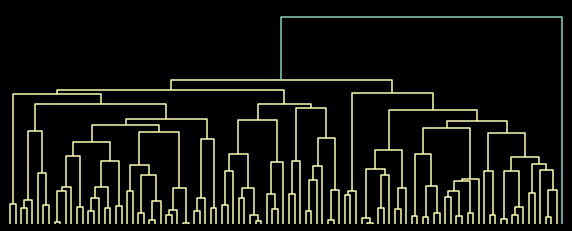

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 1.5
Disbalance: 1.036
Top levels balance: -0.174
Clustering quality: 0.657


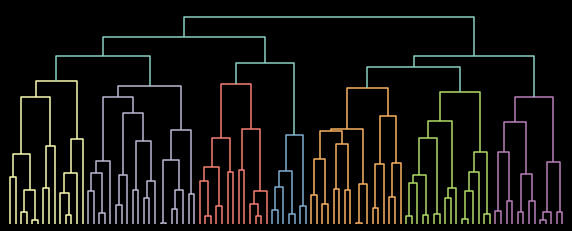

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 2
Disbalance: 1.124
Top levels balance: -0.161
Clustering quality: 0.653


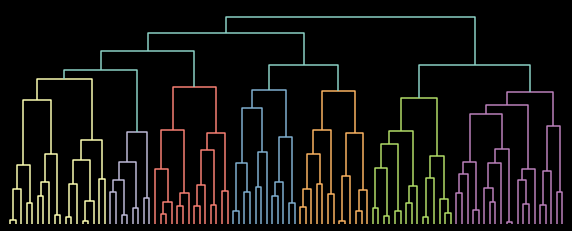

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 2.5
Disbalance: 1.189
Top levels balance: -0.205
Clustering quality: 0.662


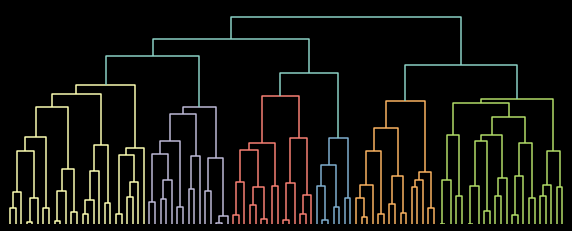

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 3
Disbalance: 1.132
Top levels balance: -0.182
Clustering quality: 0.661


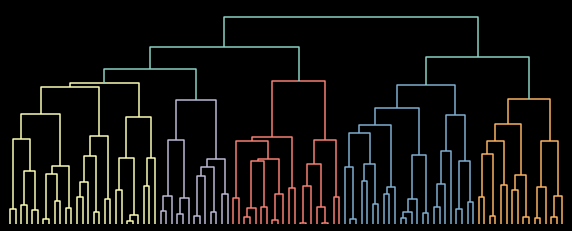

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 3.5
Disbalance: 1.249
Top levels balance: -0.228
Clustering quality: 0.660


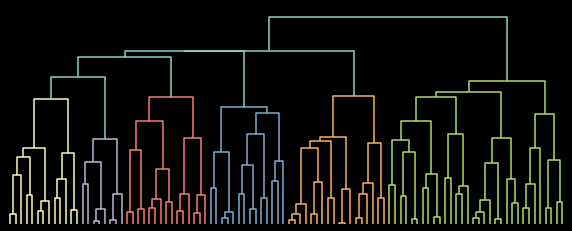

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}

alpha = 4
Disbalance: 1.088
Top levels balance: -0.165
Clustering quality: 0.657


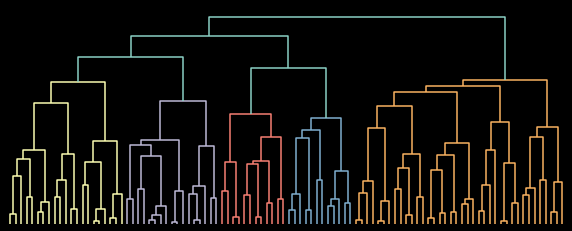

In [3]:
for alpha in [1, 1.5, 2, 2.5, 3, 3.5, 4]:
    data = Data(alpha=alpha, use_cached_forum_data=True)
    img = create_dendrogram(data._dendrogram)
    print(f"\nalpha = {alpha}")
    print(f"Disbalance: {get_disbalance(data.tree):.3f}")
    print(f"Top levels balance: {get_top_levels_balance_log(data.tree):.3f}")
    print(f"Clustering quality: {1 - normalized_dasgupta_cost(data.Tag_cooccurence, data._dendrogram):.3f}")
    display(Image.open(img))

In [4]:
balances = []
top_balances = []
clustering_qualities = []
alphas = np.linspace(1, 3, num=21)
for alpha in alphas:
    data = Data(alpha=alpha, use_cached_forum_data=True)
    balances.append(get_disbalance(data.tree))
    top_balances.append(get_top_levels_balance_log(data.tree, levels=5))
    clustering_qualities.append(1 - normalized_dasgupta_cost(data.Tag_cooccurence, data._dendrogram))

{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQR6Saq3u3t22vZ': 1, 'ZsW45yAqDqQQgcNnk': 1, 'dHcHjoPQB2HXouD6w': 1}
{'sWcuTyTB5dP3nas2t': 1, 'NTEQ

In [5]:
# plot balances and clusterig qualities, with different scales
plt.plot(alphas, top_balances, label="top levels balance")
plt.legend()

In [6]:
plt.plot(alphas, clustering_qualities, label="clustering quality")
plt.legend()

In [7]:
plt.plot(alphas, balances, label="disbalance")
plt.legend()